In [1]:
from convexness.convexness import *
import glob
import os
import open3d as o3d
import pandas as pd
from tqdm import tqdm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
n_random_samples = 10000
min_fragments = 3
max_fragments = 8
num_points = 5000

In [3]:
def process_our_folder(folder, dataset_index):
    target_extension = '.stl'
    metadata_pattern = '*_mesh.txt'
    path = folder + '*/' + metadata_pattern
    mesh_files = glob.glob(folder + '*/' + metadata_pattern, recursive=True)
    
    #
    global_df = None
    
    for metadata_file in mesh_files:
        df = pd.read_csv(metadata_file, sep='\t', header=0, index_col=False)
        
        # maintain only a subset of the columns
        df = df[['Filename', 'Percentage', 'Vertices', 'Faces']]
        if global_df is None:
            global_df = df
        else:
            global_df = pd.concat([global_df, df], ignore_index=True)
            
    # filter files by target extension
    global_df = global_df[global_df['Filename'].str.contains(target_extension)]
            
    # create a new column with the number of fragments
    global_df['Fragments'] = global_df['Filename'].apply(lambda x: int(x.split('f_')[0].split('_')[-1]))
    # select n random samples
    global_df = global_df[max_fragments >= global_df['Fragments']]  
    global_df = global_df[min_fragments <= global_df['Fragments']]
    
    print('Number of fragments:', global_df.shape[0])
    
    global_df = global_df.sample(n=min(n_random_samples, global_df.shape[0]))

    # iterate to calculate the convexness
    for index, row in tqdm(global_df.iterrows(), total=global_df.shape[0]):
        filename = row['Filename']
        filename = filename.replace('E:/Fragments/', 'D:/allopezr/Fragments/Artifacts_200_ours_stl/')
        if dataset_index == 1:
            filename = filename.replace('C:/Github/MeshFragments/MeshFragments/Assets/Models/Artifacts/Fragments/', 'D:/allopezr/Fragments/Artifacts_200_ours_stl_2/')
        elif dataset_index == 2:
            filename = filename.replace('C:/Github/MeshFragments/MeshFragments/Assets/Models/Artifacts/Fragments/', 'D:/allopezr/Fragments/Artifacts_200_ours_stl_3/')
        
        mesh = trimesh.load_mesh(filename)
        # normalize the mesh
        mesh.vertices -= mesh.vertices.mean(axis=0)
        mesh.vertices /= np.abs(mesh.vertices).max()
        
        try:
            convexness = measure_convexness_2(mesh, num_points, 1)
            global_df.loc[index, 'Convexness'] = convexness
        except:
            print('Error:', filename)
            global_df = global_df.drop(index)
        
    return global_df

In [4]:
def process_voronoi_folder(folder):
    target_extension = '.obj'
    files = glob.glob(folder + '*/*' + target_extension, recursive=True)
    # get number of fragments as the first number in the filename before '_'
    global_df = pd.DataFrame(columns=['Filename', 'Fragments'])
    for file in files:
        file_name = os.path.basename(file)
        fragments = int(file_name.split('_')[0])
        global_df = pd.concat([global_df, pd.DataFrame({'Filename': [file], 'Fragments': [fragments]})], ignore_index=True)
        
    # filter by the number of fragments
    global_df = global_df[max_fragments >= global_df['Fragments']]
    global_df = global_df[min_fragments <= global_df['Fragments']] 
    
    # random sampling
    print('Number of fragments:', global_df.shape[0])
    random_rows = global_df.sample(n=min(n_random_samples, global_df.shape[0]))
    for index, row in tqdm(random_rows.iterrows()):
        filename = row['Filename']
        mesh = trimesh.load_mesh(filename)
        
        # normalize the mesh
        mesh.vertices -= mesh.vertices.mean(axis=0)
        mesh.vertices /= np.abs(mesh.vertices).max()
        
        try:
            convexness = measure_convexness_2(mesh, num_points, 1)
            global_df.loc[index, 'Convexness'] = convexness
        except:
            print('Error:', filename)
            global_df = global_df.drop(index)
        
    # remove rows with NaN values
    global_df = global_df.dropna()
    
    return global_df

In [5]:
def process_sellan_folder(folder):
    # find subfolders
    subfolders = glob.glob(folder + '*/*/')
    global_df = pd.DataFrame(columns=['Filename', 'Fragments'])
    
    for subfolder in subfolders:
        # find obj inside the subfolder
        files = glob.glob(subfolder + '*.obj')
        n_fragments = len(files)
        
        if min_fragments<= n_fragments <= max_fragments:          
            for file in files:
                global_df = pd.concat([global_df, pd.DataFrame({'Filename': [file], 'Fragments': [n_fragments]})], ignore_index=True)
            
    print('Number of fragments:', global_df.shape[0])
            
    # read the mesh
    random_rows = global_df.sample(n=min(n_random_samples, global_df.shape[0]))
    for index, row in tqdm(random_rows.iterrows()):
        filename = row['Filename']
        mesh = trimesh.load_mesh(filename)
        # normalize the mesh
        mesh.vertices -= mesh.vertices.mean(axis=0)
        mesh.vertices /= np.abs(mesh.vertices).max()
        
        try:
            convexness = measure_convexness_2(mesh, num_points, 1)
            global_df.loc[index, 'Convexness'] = convexness
        except:
            print('Error:', filename)
            global_df = global_df.drop(index)
        
    # remove rows with NaN values
    global_df = global_df.dropna()
    
    return global_df

In [ ]:
#folders = ['D:/allopezr/Fragments/Vessels_200_Voronoi/', 'D:/allopezr/Fragments/vessels_200_obj_ply_no_zipped/vessels_200_obj_ply/']

folders = ['D:/allopezr/Fragments/Artifacts_200_CellFracture/', 'D:/allopezr/Fragments/Artifacts_200_ours_stl/', 'D:/allopezr/Fragments/Artifacts_200_ours_stl_2/', 'D:/allopezr/Fragments/Artifacts_200_ours_stl_3/', 'D:/allopezr/Datasets/BreakingBad/artifact/']

#folders = ['D:/allopezr/Datasets/BreakingBad/artifact_compressed/']
results = []

for index, folder in tqdm(enumerate(folders)):
    print(folder)
    
    if 'CellFracture' in folder:
        global_df = process_voronoi_folder(folder)
    elif 'BreakingBad' in folder:
        global_df = process_sellan_folder(folder)
    else:
        global_df = process_our_folder(folder, index - 1) 
        
    results.append(global_df[['Fragments', 'Convexness']])

0it [00:00, ?it/s]

D:/allopezr/Fragments/Artifacts_200_CellFracture/
Number of fragments: 812



0it [00:00, ?it/s]
1it [00:00,  6.49it/s]
2it [00:00,  6.25it/s]
3it [00:01,  2.50it/s]
4it [00:01,  3.34it/s]
5it [00:01,  4.02it/s]
6it [00:01,  4.02it/s]
7it [00:01,  4.70it/s]
8it [00:01,  4.20it/s]
9it [00:02,  4.42it/s]
10it [00:02,  3.87it/s]
11it [00:02,  4.45it/s]
12it [00:02,  4.43it/s]
13it [00:03,  3.43it/s]
14it [00:03,  3.85it/s]
15it [00:03,  3.69it/s]
16it [00:03,  4.23it/s]
17it [00:04,  4.77it/s]
18it [00:04,  4.42it/s]
19it [00:04,  3.89it/s]
20it [00:04,  4.39it/s]
21it [00:05,  3.91it/s]
22it [00:05,  4.19it/s]
23it [00:05,  4.21it/s]
24it [00:05,  4.89it/s]
25it [00:05,  5.56it/s]
26it [00:06,  4.78it/s]
27it [00:06,  4.29it/s]
28it [00:06,  3.81it/s]
29it [00:07,  3.11it/s]
30it [00:07,  3.17it/s]
31it [00:07,  3.39it/s]
32it [00:08,  3.67it/s]
33it [00:08,  4.28it/s]
34it [00:08,  4.35it/s]
35it [00:08,  5.07it/s]
36it [00:08,  4.28it/s]
37it [00:08,  4.74it/s]
38it [00:09,  4.65it/s]
39it [00:09,  5.15it/s]
41it [00:09,  6.64it/s]
42it [00:09,  6.81it/s]
43it 

Error: D:/allopezr/Fragments/Artifacts_200_CellFracture\180\5_180.compressed_mesh_cell.006.obj



71it [00:16,  6.27it/s]
73it [00:17,  6.72it/s]
74it [00:17,  6.93it/s]
75it [00:17,  6.78it/s]
76it [00:17,  5.57it/s]
77it [00:17,  5.27it/s]
78it [00:18,  5.16it/s]
79it [00:18,  4.98it/s]
80it [00:18,  5.02it/s]
81it [00:18,  5.36it/s]
82it [00:18,  6.13it/s]
83it [00:19,  4.09it/s]


Error: D:/allopezr/Fragments/Artifacts_200_CellFracture\180\5_180.compressed_mesh_cell.010.obj


85it [00:19,  5.46it/s]
86it [00:19,  5.15it/s]
87it [00:19,  4.44it/s]
89it [00:20,  5.25it/s]
90it [00:20,  5.58it/s]
91it [00:20,  5.77it/s]
92it [00:20,  5.36it/s]
93it [00:20,  5.64it/s]
94it [00:21,  5.83it/s]
96it [00:21,  5.35it/s]
97it [00:21,  5.90it/s]
98it [00:21,  6.17it/s]
99it [00:21,  5.83it/s]
100it [00:22,  6.56it/s]
101it [00:22,  6.64it/s]
102it [00:23,  2.46it/s]
103it [00:23,  2.51it/s]
104it [00:23,  2.81it/s]
105it [00:24,  3.27it/s]
106it [00:24,  3.94it/s]
107it [00:24,  4.08it/s]
108it [00:24,  4.82it/s]
109it [00:24,  5.59it/s]
111it [00:24,  5.79it/s]
112it [00:25,  5.43it/s]
113it [00:25,  5.10it/s]
114it [00:25,  5.60it/s]
115it [00:25,  4.87it/s]
116it [00:26,  4.58it/s]
117it [00:26,  5.08it/s]
118it [00:26,  5.35it/s]
119it [00:26,  5.69it/s]
120it [00:26,  5.11it/s]
121it [00:26,  4.85it/s]
122it [00:27,  4.68it/s]
123it [00:27,  3.86it/s]
124it [00:27,  3.86it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\numpy\core\fromnumeric.py:3464

Error: D:/allopezr/Fragments/Artifacts_200_CellFracture\118\5_118.compressed_mesh_cell.011.obj



150it [00:33,  5.33it/s]
151it [00:33,  5.65it/s]
153it [00:33,  6.75it/s]
154it [00:33,  5.19it/s]
155it [00:34,  5.17it/s]
156it [00:34,  5.29it/s]
157it [00:34,  4.88it/s]
158it [00:34,  4.19it/s]
159it [00:35,  3.98it/s]
160it [00:35,  4.21it/s]
161it [00:35,  4.15it/s]
162it [00:35,  3.81it/s]
163it [00:36,  4.10it/s]
164it [00:36,  4.78it/s]
165it [00:36,  5.61it/s]
167it [00:36,  6.67it/s]
168it [00:36,  5.24it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

169it [00:37,  4.58it/s]

Error: D:/allopezr/Fragments/Artifacts_200_CellFracture\33\7_33.compressed_mesh_cell.007.obj



171it [00:37,  5.11it/s]
172it [00:37,  5.46it/s]
173it [00:37,  6.11it/s]
174it [00:38,  6.16it/s]
175it [00:38,  4.21it/s]
177it [00:38,  5.41it/s]
178it [00:38,  5.58it/s]
179it [00:38,  5.96it/s]
180it [00:39,  5.31it/s]
181it [00:39,  5.51it/s]
182it [00:39,  5.52it/s]
183it [00:39,  5.83it/s]
184it [00:39,  5.20it/s]
185it [00:40,  5.62it/s]
186it [00:40,  5.67it/s]
187it [00:40,  6.16it/s]
188it [00:40,  5.43it/s]
189it [00:40,  6.14it/s]
190it [00:40,  6.18it/s]
191it [00:41,  6.11it/s]
193it [00:41,  6.73it/s]
194it [00:41,  6.29it/s]
195it [00:41,  6.08it/s]
196it [00:41,  6.77it/s]
197it [00:42,  5.41it/s]
198it [00:42,  4.30it/s]
199it [00:42,  4.32it/s]
200it [00:42,  4.73it/s]
201it [00:43,  4.26it/s]
202it [00:43,  2.98it/s]
203it [00:44,  3.02it/s]
204it [00:44,  3.30it/s]
205it [00:44,  3.85it/s]
206it [00:44,  4.27it/s]
207it [00:44,  5.02it/s]
208it [00:44,  4.77it/s]
209it [00:45,  4.97it/s]
210it [00:45,  3.43it/s]
211it [00:45,  3.97it/s]
212it [00:46,  3.73it/s]

Error: D:/allopezr/Fragments/Artifacts_200_CellFracture\118\5_118.compressed_mesh_cell.008.obj



302it [01:03,  5.22it/s]
303it [01:03,  5.34it/s]
304it [01:03,  4.57it/s]
305it [01:04,  5.38it/s]
306it [01:04,  3.97it/s]
307it [01:04,  4.72it/s]
308it [01:04,  4.15it/s]
309it [01:05,  4.15it/s]
310it [01:05,  3.51it/s]
311it [01:05,  3.70it/s]
312it [01:05,  3.81it/s]
313it [01:06,  4.59it/s]
314it [01:06,  4.70it/s]
316it [01:06,  5.73it/s]
317it [01:06,  5.93it/s]
318it [01:06,  6.12it/s]
319it [01:07,  3.99it/s]
321it [01:07,  5.49it/s]
322it [01:07,  6.10it/s]
323it [01:07,  6.17it/s]
325it [01:07,  7.54it/s]

Error: D:/allopezr/Fragments/Artifacts_200_CellFracture\88\7_88.compressed_mesh_cell.008.obj



326it [01:08,  7.64it/s]
327it [01:08,  6.02it/s]
328it [01:08,  6.40it/s]
330it [01:08,  7.03it/s]
331it [01:08,  6.35it/s]
332it [01:09,  5.95it/s]
333it [01:09,  6.05it/s]
334it [01:09,  5.63it/s]
336it [01:09,  7.24it/s]
337it [01:09,  6.17it/s]
338it [01:10,  5.58it/s]
340it [01:10,  6.11it/s]
341it [01:10,  6.15it/s]
342it [01:10,  5.61it/s]
343it [01:10,  5.87it/s]
345it [01:11,  6.59it/s]
346it [01:11,  6.55it/s]
347it [01:11,  6.53it/s]
348it [01:11,  6.89it/s]

Error: D:/allopezr/Fragments/Artifacts_200_CellFracture\168\8_168.compressed_mesh_cell.009.obj



350it [01:12,  6.21it/s]
352it [01:12,  7.49it/s]
353it [01:12,  7.05it/s]
355it [01:12,  7.72it/s]
357it [01:12,  7.08it/s]
358it [01:13,  5.75it/s]
360it [01:13,  5.75it/s]
361it [01:13,  5.32it/s]
362it [01:13,  5.51it/s]
363it [01:14,  3.85it/s]
364it [01:14,  4.26it/s]
365it [01:14,  4.41it/s]
366it [01:15,  4.31it/s]
367it [01:15,  3.72it/s]
368it [01:15,  4.46it/s]
369it [01:15,  4.67it/s]
370it [01:15,  5.06it/s]
371it [01:16,  5.12it/s]
373it [01:16,  6.14it/s]
374it [01:16,  5.83it/s]
375it [01:16,  5.43it/s]
376it [01:16,  6.06it/s]
378it [01:17,  7.27it/s]
379it [01:17,  6.76it/s]
380it [01:17,  5.72it/s]
381it [01:17,  5.82it/s]
382it [01:18,  4.30it/s]
383it [01:18,  4.87it/s]
384it [01:18,  4.14it/s]
385it [01:18,  4.68it/s]
386it [01:19,  3.66it/s]
387it [01:19,  3.69it/s]
388it [01:19,  3.75it/s]
389it [01:19,  3.37it/s]
390it [01:20,  3.52it/s]
391it [01:20,  4.17it/s]
392it [01:20,  4.73it/s]
393it [01:21,  3.20it/s]
394it [01:21,  3.70it/s]
395it [01:21,  4.28it/s]

Error: D:/allopezr/Fragments/Artifacts_200_CellFracture\67\5_67.compressed_mesh_cell.006.obj


548it [01:51,  5.88it/s]
549it [01:51,  6.26it/s]
550it [01:52,  6.30it/s]
551it [01:52,  6.54it/s]
552it [01:52,  6.26it/s]
553it [01:52,  6.61it/s]
554it [01:52,  6.03it/s]
555it [01:53,  2.79it/s]
556it [01:53,  3.31it/s]
557it [01:53,  4.05it/s]
558it [01:53,  4.53it/s]
560it [01:54,  5.21it/s]
561it [01:54,  4.82it/s]
562it [01:54,  5.12it/s]
563it [01:54,  4.63it/s]
564it [01:55,  4.80it/s]
565it [01:55,  4.08it/s]
566it [01:56,  2.37it/s]
567it [01:56,  2.77it/s]
568it [01:56,  3.50it/s]
569it [01:56,  3.72it/s]
570it [01:56,  4.35it/s]
571it [01:57,  5.16it/s]
572it [01:57,  5.64it/s]
573it [01:57,  5.86it/s]
574it [01:57,  5.12it/s]
575it [01:57,  5.76it/s]
576it [01:57,  5.82it/s]
578it [01:58,  7.17it/s]
579it [01:58,  6.58it/s]
580it [01:58,  6.08it/s]
581it [01:58,  5.95it/s]
582it [01:58,  5.18it/s]
583it [01:59,  4.82it/s]
584it [01:59,  5.34it/s]
585it [01:59,  6.10it/s]
586it [01:59,  6.58it/s]
588it [01:59,  8.07it/s]

Error: D:/allopezr/Fragments/Artifacts_200_CellFracture\118\5_118.compressed_mesh_cell.009.obj



589it [01:59,  7.84it/s]
590it [02:00,  7.42it/s]
591it [02:00,  4.87it/s]
592it [02:00,  5.05it/s]
593it [02:01,  4.04it/s]
594it [02:01,  4.36it/s]
595it [02:01,  4.73it/s]
596it [02:01,  4.80it/s]
597it [02:01,  5.26it/s]
598it [02:01,  5.03it/s]
599it [02:02,  4.80it/s]
600it [02:02,  5.27it/s]
601it [02:02,  5.86it/s]
603it [02:02,  7.61it/s]
604it [02:02,  7.60it/s]
605it [02:02,  7.70it/s]
606it [02:03,  6.98it/s]
607it [02:03,  7.55it/s]
608it [02:03,  7.67it/s]
609it [02:03,  7.06it/s]
610it [02:03,  6.18it/s]
611it [02:03,  5.98it/s]
612it [02:04,  5.49it/s]
613it [02:04,  5.54it/s]
614it [02:04,  5.27it/s]
615it [02:04,  5.59it/s]
616it [02:04,  5.88it/s]
617it [02:05,  4.13it/s]
618it [02:05,  3.84it/s]
620it [02:05,  5.23it/s]
621it [02:05,  4.86it/s]
622it [02:06,  5.30it/s]
623it [02:06,  4.47it/s]
624it [02:06,  4.11it/s]
626it [02:06,  5.62it/s]
627it [02:06,  6.05it/s]
628it [02:07,  5.55it/s]
629it [02:07,  5.19it/s]
630it [02:07,  4.86it/s]
631it [02:07,  5.28it/s]

Error: D:/allopezr/Fragments/Artifacts_200_CellFracture\102\5_102.compressed_mesh_cell.005.obj



687it [02:19,  5.24it/s]
688it [02:20,  4.61it/s]
689it [02:20,  5.28it/s]
690it [02:20,  4.57it/s]
691it [02:20,  5.30it/s]
692it [02:20,  4.61it/s]
693it [02:21,  4.48it/s]
695it [02:21,  5.84it/s]
696it [02:21,  6.14it/s]
697it [02:21,  6.12it/s]
698it [02:22,  4.87it/s]
699it [02:22,  4.43it/s]
700it [02:22,  4.44it/s]
701it [02:22,  4.76it/s]
702it [02:23,  3.98it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(


Error: D:/allopezr/Fragments/Artifacts_200_CellFracture\21\3_21.compressed_mesh_cell.003.obj



704it [02:23,  4.43it/s]
705it [02:23,  4.68it/s]
706it [02:24,  3.70it/s]
707it [02:24,  3.75it/s]
708it [02:24,  3.60it/s]
709it [02:24,  4.27it/s]
710it [02:24,  4.62it/s]
711it [02:25,  5.25it/s]
712it [02:25,  4.88it/s]
713it [02:25,  4.60it/s]
714it [02:25,  5.48it/s]
715it [02:25,  6.00it/s]
717it [02:26,  6.59it/s]
718it [02:26,  6.25it/s]
719it [02:26,  4.65it/s]
720it [02:26,  4.79it/s]
721it [02:27,  4.42it/s]
722it [02:27,  4.85it/s]
723it [02:27,  4.59it/s]
725it [02:27,  5.19it/s]
726it [02:28,  4.81it/s]
727it [02:28,  5.41it/s]
728it [02:28,  5.14it/s]
729it [02:28,  5.25it/s]
730it [02:28,  5.16it/s]
731it [02:29,  3.77it/s]
732it [02:29,  3.98it/s]
733it [02:29,  4.54it/s]
734it [02:29,  5.20it/s]
735it [02:29,  5.05it/s]
736it [02:30,  5.36it/s]
737it [02:30,  6.11it/s]
738it [02:30,  6.66it/s]
739it [02:30,  4.41it/s]
740it [02:30,  4.25it/s]
741it [02:31,  4.88it/s]
742it [02:31,  3.67it/s]
743it [02:32,  2.92it/s]
744it [02:32,  3.49it/s]
745it [02:32,  4.00it/s]

D:/allopezr/Fragments/Artifacts_200_ours_stl/
Number of fragments: 9933



  0%|          | 9/9933 [00:02<49:22,  3.35it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

  5%|▌         | 523/9933 [02:43<47:47,  3.28it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

  5%|▌         | 524/9933 [02:44<54:37,  2.87it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_7f_128r_3it_6_10000t.stl



  7%|▋         | 718/9933 [03:42<39:52,  3.85it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

 12%|█▏        | 1189/9933 [06:12<1:11:54,  2.03it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 12%|█▏        | 1190/9933 [06:13<57:48,  2.52it/s]  

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_8f_128r_0it_7_10000t.stl



 13%|█▎        | 1309/9933 [06:47<42:28,  3.38it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(


Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_8f_128r_1it_6_10000t.stl



 15%|█▌        | 1527/9933 [07:51<39:18,  3.56it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 15%|█▌        | 1528/9933 [07:51<39:37,  3.54it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_3f_128r_3it_1_10000t.stl



 17%|█▋        | 1690/9933 [08:45<41:21,  3.32it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 17%|█▋        | 1691/9933 [08:45<36:51,  3.73it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_7f_128r_2it_4_10000t.stl



 20%|█▉        | 1970/9933 [10:05<42:44,  3.10it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 20%|█▉        | 1971/9933 [10:05<43:41,  3.04it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_8f_128r_5it_7_10000t.stl



 26%|██▌       | 2548/9933 [12:59<43:00,  2.86it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 26%|██▌       | 2549/9933 [13:00<41:43,  2.95it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_7f_128r_4it_5_10000t.stl



 29%|██▉       | 2871/9933 [14:36<38:20,  3.07it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 29%|██▉       | 2872/9933 [14:36<30:21,  3.88it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_6f_128r_5it_4_10000t.stl



 31%|███       | 3040/9933 [15:26<31:35,  3.64it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

 33%|███▎      | 3254/9933 [16:29<29:36,  3.76it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 33%|███▎      | 3255/9933 [16:29<33:44,  3.30it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_3f_128r_3it_2_10000t.stl



 33%|███▎      | 3256/9933 [16:30<34:51,  3.19it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 33%|███▎      | 3257/9933 [16:30<29:44,  3.74it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_8f_128r_2it_5_10000t.stl



 38%|███▊      | 3811/9933 [19:11<27:46,  3.67it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 38%|███▊      | 3812/9933 [19:11<32:10,  3.17it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_4f_128r_7it_3_10000t.stl



 39%|███▉      | 3871/9933 [19:28<34:32,  2.92it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 39%|███▉      | 3872/9933 [19:29<38:07,  2.65it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_7f_128r_2it_6_10000t.stl



 40%|███▉      | 3961/9933 [19:54<30:44,  3.24it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 40%|███▉      | 3962/9933 [19:55<37:23,  2.66it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_5f_128r_7it_4_10000t.stl



 43%|████▎     | 4224/9933 [21:14<32:36,  2.92it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 43%|████▎     | 4225/9933 [21:14<26:41,  3.56it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_6f_128r_3it_4_10000t.stl



 43%|████▎     | 4232/9933 [21:17<29:32,  3.22it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 43%|████▎     | 4233/9933 [21:17<37:56,  2.50it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_7f_128r_5it_6_10000t.stl



 43%|████▎     | 4299/9933 [21:39<28:05,  3.34it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 43%|████▎     | 4300/9933 [21:39<30:35,  3.07it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_5f_128r_5it_4_10000t.stl



 45%|████▌     | 4474/9933 [22:29<24:48,  3.67it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 45%|████▌     | 4475/9933 [22:30<25:34,  3.56it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_8f_128r_2it_7_10000t.stl



 46%|████▌     | 4553/9933 [22:53<26:45,  3.35it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

 50%|████▉     | 4943/9933 [24:51<23:12,  3.58it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 50%|████▉     | 4944/9933 [24:51<23:13,  3.58it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_7f_128r_4it_6_10000t.stl



 53%|█████▎    | 5257/9933 [26:21<23:41,  3.29it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 53%|█████▎    | 5258/9933 [26:21<27:32,  2.83it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_8f_128r_4it_7_10000t.stl



 57%|█████▋    | 5673/9933 [28:20<22:43,  3.12it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 57%|█████▋    | 5674/9933 [28:21<24:35,  2.89it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_5f_128r_1it_4_10000t.stl



 58%|█████▊    | 5743/9933 [28:43<21:03,  3.32it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 58%|█████▊    | 5744/9933 [28:43<20:57,  3.33it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_8f_128r_5it_6_10000t.stl



 59%|█████▉    | 5898/9933 [29:29<20:30,  3.28it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

 66%|██████▋   | 6602/9933 [32:53<16:05,  3.45it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 66%|██████▋   | 6603/9933 [32:53<19:41,  2.82it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_5f_128r_3it_4_10000t.stl



 70%|██████▉   | 6932/9933 [34:28<13:49,  3.62it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 70%|██████▉   | 6933/9933 [34:29<11:38,  4.29it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_8f_128r_0it_5_10000t.stl



 75%|███████▍  | 7422/9933 [36:53<13:02,  3.21it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(


Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_3f_128r_2it_1_10000t.stl



 76%|███████▌  | 7545/9933 [37:30<11:55,  3.34it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 76%|███████▌  | 7546/9933 [37:30<09:54,  4.01it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_5f_128r_6it_3_10000t.stl



 86%|████████▌ | 8494/9933 [42:13<05:34,  4.30it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 86%|████████▌ | 8495/9933 [42:14<08:29,  2.82it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_8f_128r_3it_7_10000t.stl



 88%|████████▊ | 8707/9933 [43:18<06:00,  3.40it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 88%|████████▊ | 8708/9933 [43:19<05:47,  3.53it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_8f_128r_2it_6_10000t.stl



 88%|████████▊ | 8769/9933 [43:36<05:55,  3.27it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 88%|████████▊ | 8770/9933 [43:37<07:32,  2.57it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl/113.compressed_mesh/113.compressed_mesh_4f_128r_3it_3_10000t.stl



 89%|████████▊ | 8807/9933 [43:48<04:58,  3.77it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

100%|██████████| 9933/9933 [49:17<00:00,  3.36it/s]
2it [52:10, 1812.16s/it]

D:/allopezr/Fragments/Artifacts_200_ours_stl_2/
Number of fragments: 13200



  3%|▎         | 254/10000 [01:13<43:32,  3.73it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

  7%|▋         | 714/10000 [03:26<40:50,  3.79it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

  7%|▋         | 715/10000 [03:26<40:50,  3.79it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_2/98.compressed_mesh/98.compressed_mesh_6f_128r_0it_5_10000t.stl



 15%|█▌        | 1533/10000 [07:19<38:36,  3.65it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 15%|█▌        | 1534/10000 [07:19<38:42,  3.64it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_2/98.compressed_mesh/98.compressed_mesh_8f_128r_1it_7_10000t.stl



 16%|█▌        | 1605/10000 [07:40<41:18,  3.39it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 16%|█▌        | 1606/10000 [07:40<41:17,  3.39it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_2/113.compressed_mesh/113.compressed_mesh_8f_128r_1it_7_10000t.stl



 23%|██▎       | 2333/10000 [11:08<41:12,  3.10it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(


Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_2/48.compressed_mesh/48.compressed_mesh_7f_128r_1it_5_10000t.stl



 25%|██▍       | 2472/10000 [11:47<37:12,  3.37it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 25%|██▍       | 2473/10000 [11:48<36:04,  3.48it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_2/98.compressed_mesh/98.compressed_mesh_4f_128r_0it_1_10000t.stl



 27%|██▋       | 2690/10000 [12:49<33:38,  3.62it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 27%|██▋       | 2691/10000 [12:50<28:22,  4.29it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_2/48.compressed_mesh/48.compressed_mesh_5f_128r_1it_3_10000t.stl



 37%|███▋      | 3730/10000 [17:43<26:25,  3.96it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 37%|███▋      | 3731/10000 [17:43<23:47,  4.39it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_2/98.compressed_mesh/98.compressed_mesh_8f_128r_1it_6_10000t.stl



 38%|███▊      | 3847/10000 [18:16<28:23,  3.61it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 38%|███▊      | 3848/10000 [18:17<31:37,  3.24it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_2/113.compressed_mesh/113.compressed_mesh_5f_128r_1it_4_10000t.stl



 44%|████▍     | 4417/10000 [20:56<25:23,  3.66it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 44%|████▍     | 4418/10000 [20:57<24:08,  3.85it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_2/98.compressed_mesh/98.compressed_mesh_6f_128r_1it_5_10000t.stl



 46%|████▌     | 4613/10000 [21:52<27:18,  3.29it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 46%|████▌     | 4614/10000 [21:52<30:38,  2.93it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_2/113.compressed_mesh/113.compressed_mesh_8f_128r_0it_7_10000t.stl



 58%|█████▊    | 5814/10000 [27:31<20:45,  3.36it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 58%|█████▊    | 5815/10000 [27:32<24:17,  2.87it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_2/113.compressed_mesh/113.compressed_mesh_6f_128r_0it_5_10000t.stl



 61%|██████▏   | 6149/10000 [29:05<17:49,  3.60it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 62%|██████▏   | 6150/10000 [29:05<19:49,  3.24it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_2/113.compressed_mesh/113.compressed_mesh_4f_128r_0it_3_10000t.stl



 62%|██████▏   | 6166/10000 [29:10<19:38,  3.25it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 62%|██████▏   | 6167/10000 [29:10<15:49,  4.04it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_2/48.compressed_mesh/48.compressed_mesh_4f_128r_0it_3_10000t.stl



 71%|███████   | 7065/10000 [33:19<15:46,  3.10it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 71%|███████   | 7066/10000 [33:19<17:11,  2.84it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_2/98.compressed_mesh/98.compressed_mesh_5f_128r_0it_4_10000t.stl



 77%|███████▋  | 7655/10000 [36:03<10:18,  3.79it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 77%|███████▋  | 7656/10000 [36:03<08:49,  4.42it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_2/48.compressed_mesh/48.compressed_mesh_6f_128r_1it_5_10000t.stl



 77%|███████▋  | 7716/10000 [36:19<09:31,  4.00it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 77%|███████▋  | 7717/10000 [36:20<11:23,  3.34it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_2/98.compressed_mesh/98.compressed_mesh_4f_128r_1it_3_10000t.stl



 80%|████████  | 8038/10000 [37:47<09:11,  3.56it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 80%|████████  | 8039/10000 [37:48<07:49,  4.18it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_2/48.compressed_mesh/48.compressed_mesh_5f_128r_1it_4_10000t.stl



 87%|████████▋ | 8669/10000 [40:39<05:06,  4.35it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 87%|████████▋ | 8670/10000 [40:39<04:14,  5.22it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_2/48.compressed_mesh/48.compressed_mesh_7f_128r_0it_6_10000t.stl



 87%|████████▋ | 8732/10000 [40:55<06:05,  3.47it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 87%|████████▋ | 8733/10000 [40:56<05:00,  4.22it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_2/48.compressed_mesh/48.compressed_mesh_8f_128r_0it_6_10000t.stl



 89%|████████▉ | 8923/10000 [41:46<05:05,  3.52it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 89%|████████▉ | 8924/10000 [41:47<04:52,  3.68it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_2/98.compressed_mesh/98.compressed_mesh_5f_128r_0it_3_10000t.stl



 92%|█████████▏| 9193/10000 [43:01<03:46,  3.56it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

 93%|█████████▎| 9263/10000 [43:20<03:35,  3.42it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 93%|█████████▎| 9264/10000 [43:21<03:33,  3.45it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_2/98.compressed_mesh/98.compressed_mesh_6f_128r_0it_4_10000t.stl



 96%|█████████▌| 9569/10000 [44:46<02:08,  3.35it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)

100%|██████████| 10000/10000 [46:48<00:00,  3.56it/s]
3it [1:39:16, 2274.75s/it]

D:/allopezr/Fragments/Artifacts_200_ours_stl_3/
Number of fragments: 13200



  0%|          | 1/10000 [00:00<55:39,  2.99it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

  0%|          | 2/10000 [00:00<37:19,  4.46it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_3/48.compressed_mesh/48.compressed_mesh_8f_128r_0it_4_10000t.stl



  1%|          | 59/10000 [00:17<52:07,  3.18it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

  1%|          | 60/10000 [00:18<41:36,  3.98it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_3/48.compressed_mesh/48.compressed_mesh_8f_128r_1it_6_10000t.stl



 11%|█▏        | 1142/10000 [05:50<44:09,  3.34it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 11%|█▏        | 1143/10000 [05:51<45:01,  3.28it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_3/113.compressed_mesh/113.compressed_mesh_7f_128r_1it_4_10000t.stl



 12%|█▏        | 1235/10000 [06:19<50:31,  2.89it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 12%|█▏        | 1236/10000 [06:19<41:37,  3.51it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_3/48.compressed_mesh/48.compressed_mesh_5f_128r_0it_4_10000t.stl



 20%|██        | 2011/10000 [10:13<39:12,  3.40it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 20%|██        | 2012/10000 [10:14<39:15,  3.39it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_3/98.compressed_mesh/98.compressed_mesh_6f_128r_0it_5_10000t.stl



 21%|██        | 2098/10000 [10:39<40:20,  3.26it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 21%|██        | 2099/10000 [10:39<43:24,  3.03it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_3/98.compressed_mesh/98.compressed_mesh_5f_128r_1it_4_10000t.stl



 29%|██▉       | 2882/10000 [14:38<33:34,  3.53it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 29%|██▉       | 2883/10000 [14:38<29:18,  4.05it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_3/113.compressed_mesh/113.compressed_mesh_8f_128r_1it_7_10000t.stl



 29%|██▉       | 2899/10000 [14:43<35:21,  3.35it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 29%|██▉       | 2900/10000 [14:43<32:58,  3.59it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_3/98.compressed_mesh/98.compressed_mesh_8f_128r_1it_5_10000t.stl



 30%|███       | 3019/10000 [15:19<33:58,  3.42it/s]C:\Users\allopezr\.conda\envs\Visualizer\lib\site-packages\trimesh\caching.py:316: RuntimeWarning: invalid value encountered in divide
  return super(self.__class__, self).__itruediv__(

 30%|███       | 3020/10000 [15:19<31:06,  3.74it/s]

Error: D:/allopezr/Fragments/Artifacts_200_ours_stl_3/113.compressed_mesh/113.compressed_mesh_5f_128r_0it_4_10000t.stl



 33%|███▎      | 3335/10000 [16:54<35:30,  3.13it/s]

In [98]:
results_copy = results.copy()

In [ ]:
# calculate only for sellan
global_df = process_sellan_folder('D:/allopezr/Datasets/BreakingBad/artifact/')

In [ ]:
# substitute this result with the previous one
results[2] = global_df[['Fragments', 'Convexness']]

In [99]:
import matplotlib.pyplot as plt

# Change matplotlib style
plt.style.use('default')

font_mapping = {'family': 'Adobe Devanagari', 'weight': 'normal', 'size': 19}
plt.rc('font', **font_mapping)

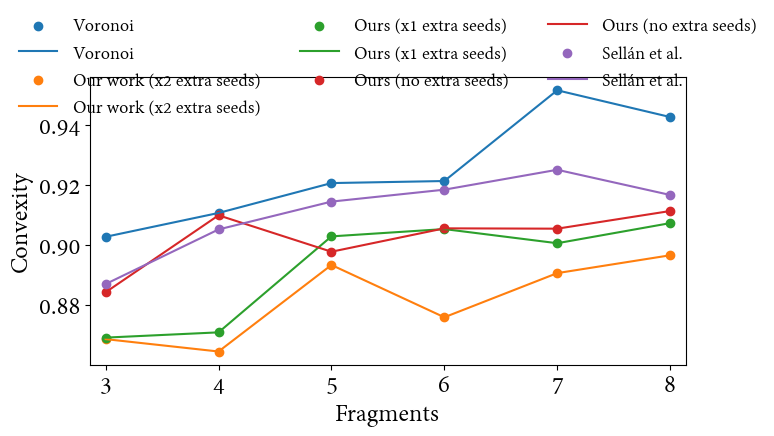

In [104]:
# render the results
import matplotlib.pyplot as plt

legends = ['Voronoi', 'Our work (x2 extra seeds)', 'Ours (x1 extra seeds)', 'Ours (no extra seeds)', 'Sellán et al.']

plt.figure(figsize=(8, 5))

# average convexness per number of fragments
for idx, (df, legend) in enumerate(zip(results, legends)):  
    df = df.dropna()
    mean = 1.0 - df.groupby('Fragments').mean()
    std = df.groupby('Fragments').std()  

    # box plot
    #plt.errorbar(mean.index, mean['Convexness'], yerr=std['Convexness'], fmt='o-', label=legend, capsize=10)
    
    # represent as points whose size is proportional to std
    plt.scatter(mean.index, mean['Convexness'], label=legend)
    
    # adjust line to mean
    plt.plot(mean.index, mean['Convexness'], label=legend)
    
plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.27), ncol=3, fontsize=14)
plt.xlabel('Fragments')
plt.ylabel('Convexity')
plt.xlim(3 - 0.14, max_fragments + 0.14)
plt.tight_layout()
plt.savefig('convexness.png', dpi=300)
plt.show()

In [ ]:
# percentil 75, 50, 25
for df in results:
    print(df['Convexness'].quantile([0.25, 0.5, 0.75]))

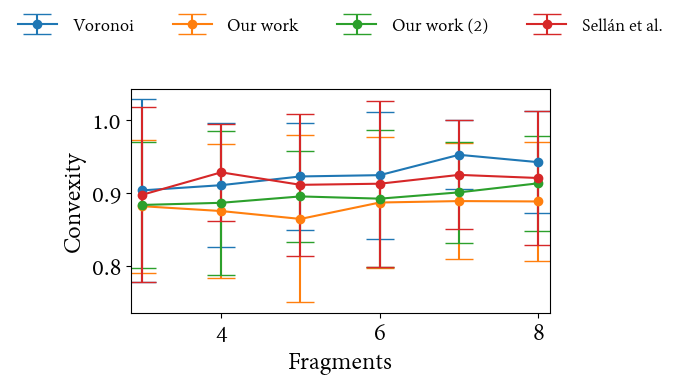

In [71]:
# chart with error bars
import matplotlib.pyplot as plt

legends = ['Voronoi', 'Our work (x2 extra seeds)', 'Ours (x1 extra seeds)', 'Ours (no extra seeds)', 'Sellán et al.']

global_mean = []
global_std = []

for idx, (df, legend) in enumerate(zip(results, legends)):  
    df = df.dropna()
    mean = 1.0 - df.groupby('Fragments').mean()
    std = df.groupby('Fragments').std()  
    
    global_mean.append(mean)
    global_std.append(std)
    
    # box plot
    plt.errorbar(mean.index, mean['Convexness'], yerr=std['Convexness'], fmt='o-', label=legend, capsize=10)
    
plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=4, fontsize=14)
plt.xlabel('Fragments')
plt.ylabel('Convexity')
plt.xlim(3 - 0.14, max_fragments + 0.14)
plt.tight_layout()
plt.savefig('convexness.png', dpi=300)
plt.show()